In [82]:
import os
from datetime import datetime
import backtrader as bt

In [83]:
def questrade_feed(ticker,time_frame):
    # DATA PATH
    ticker_path = os.path.join(os.getenv("STOCK_DATA_PATH"),'OHLC',time_frame,f'{ticker}.csv')
    # TIME FORMAT
    if time_frame[-1] in ['m','s']:
        _format = '%Y-%m-%d %H:%M:%S'
    elif time_frame[-1] in ['D','W','M']:
        _format = '%Y-%m-%d'
        
    data = bt.feeds.GenericCSVData(
        dataname=ticker_path,
        fromdate = datetime(2019,1,1),
        name=ticker,
        nullvalue=0.0,
        dtformat=_format,
        datetime=0,
        low=3,
        high=4,
        open=5,
        close=6,
        volume=7,
        openinterest=-1,
        vwap=8
    )
    return data

In [84]:
ticker = ('SPY' or input("Enter a ticker: ")).upper()
time_frame = '1D' or input("Enter a time_frame: ")
data = questrade_feed(ticker,time_frame)

In [92]:
class BarStrategy(bt.Strategy):
    
    params = (
        ('barback',5),
        ('printlog',False)
    )
    """Logging function for this strategy"""
    def log(self, txt,dt=None,doprint=False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print(f"{dt.isoformat()} >> {txt}")
        
    def __init__(self):
        """Keep ref. to close in data[0] series"""
        self.dataclose = self.datas[0].close
        # To keep track of pending orders | buy price | commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.grossprofit = 0
        self.netprofit = 0
        
    def notify_order(self,order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell Order submitted/accepted to/by broker - Nothing to do
            return
        
        # Check if an order has been completed
        # Broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED! Price: {order.executed.price} | Cost: {order.executed.value} | Comm: {order.executed.comm}')
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            elif order.issell():
                self.log(f'SELL EXECUTED! {order.executed.price} | Cost: {order.executed.value} | Comm: {order.executed.comm}')
                
            self.bar_executed = len(self)
        
        elif order.status in [order.Cancelled,order.Margin,order.Rejected]:
            sef.log('Order Cancelled/Margin/Rejected')
            
        self.order = None
        
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION PROFIT, GROSS: {trade.pnl} | NET: {trade.pnlcomm}')
        self.grossprofit+=trade.pnl
        self.netprofit+=trade.pnlcomm
        
    def next(self):
        # Log Current Closing Price of the Series
        self.log(f'Close: {self.dataclose[0]}')
        
        # Check if an order is pending >> Not sending another one if yes
        if self.order:
            return
        # Check if we are in the market
        if not self.position:
            # We might buy if conditions are right
            if self.dataclose[0] < self.dataclose[-1] < self.dataclose[-2]:
                # if current close < previous close < previous close (2 candle)
                self.log(f"BUY CREATE: {self.dataclose[0]}")
                self.order = self.buy()
        else:
            # Already in the market >> we might sell
            if len(self)>=(self.bar_executed + self.params.barback):
                # SELL WITH DEFAULT PARAMS
                self.log(f"SELL CREATE: {self.dataclose[0]}")
                # Keeping track of created order to avoid the second order
                self.order = self.sell()
    def stop(self):
        self.log(f"Param: {self.params.barback} >> EndingValue: {self.broker.getvalue()} | GROSS: {self.grossprofit} | NET: {self.netprofit}",doprint=True)

In [103]:
cerebro = bt.Cerebro()
print(f"Starting Portfolio value: {cerebro.broker.getvalue()}")
# Add a strategy
for i in range(8,9):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(TestStrategy,barback=i)
    # cerebro.optstrategy(
    #     TestStrategy,
    #     period=3
    # )

    cerebro.adddata(data)

    cerebro.broker.setcommission(commission=0.001)

    cerebro.run()
# print(f"Final Portfolio Value: {cerebro.broker.getvalue()}")

Starting Portfolio value: 10000.0
2022-02-03 >> Param: 8 >> EndingValue: 10182.599119999997 | GROSS: 217.64000000000013 | NET: 182.5991200000001


<IPython.core.display.Javascript object>


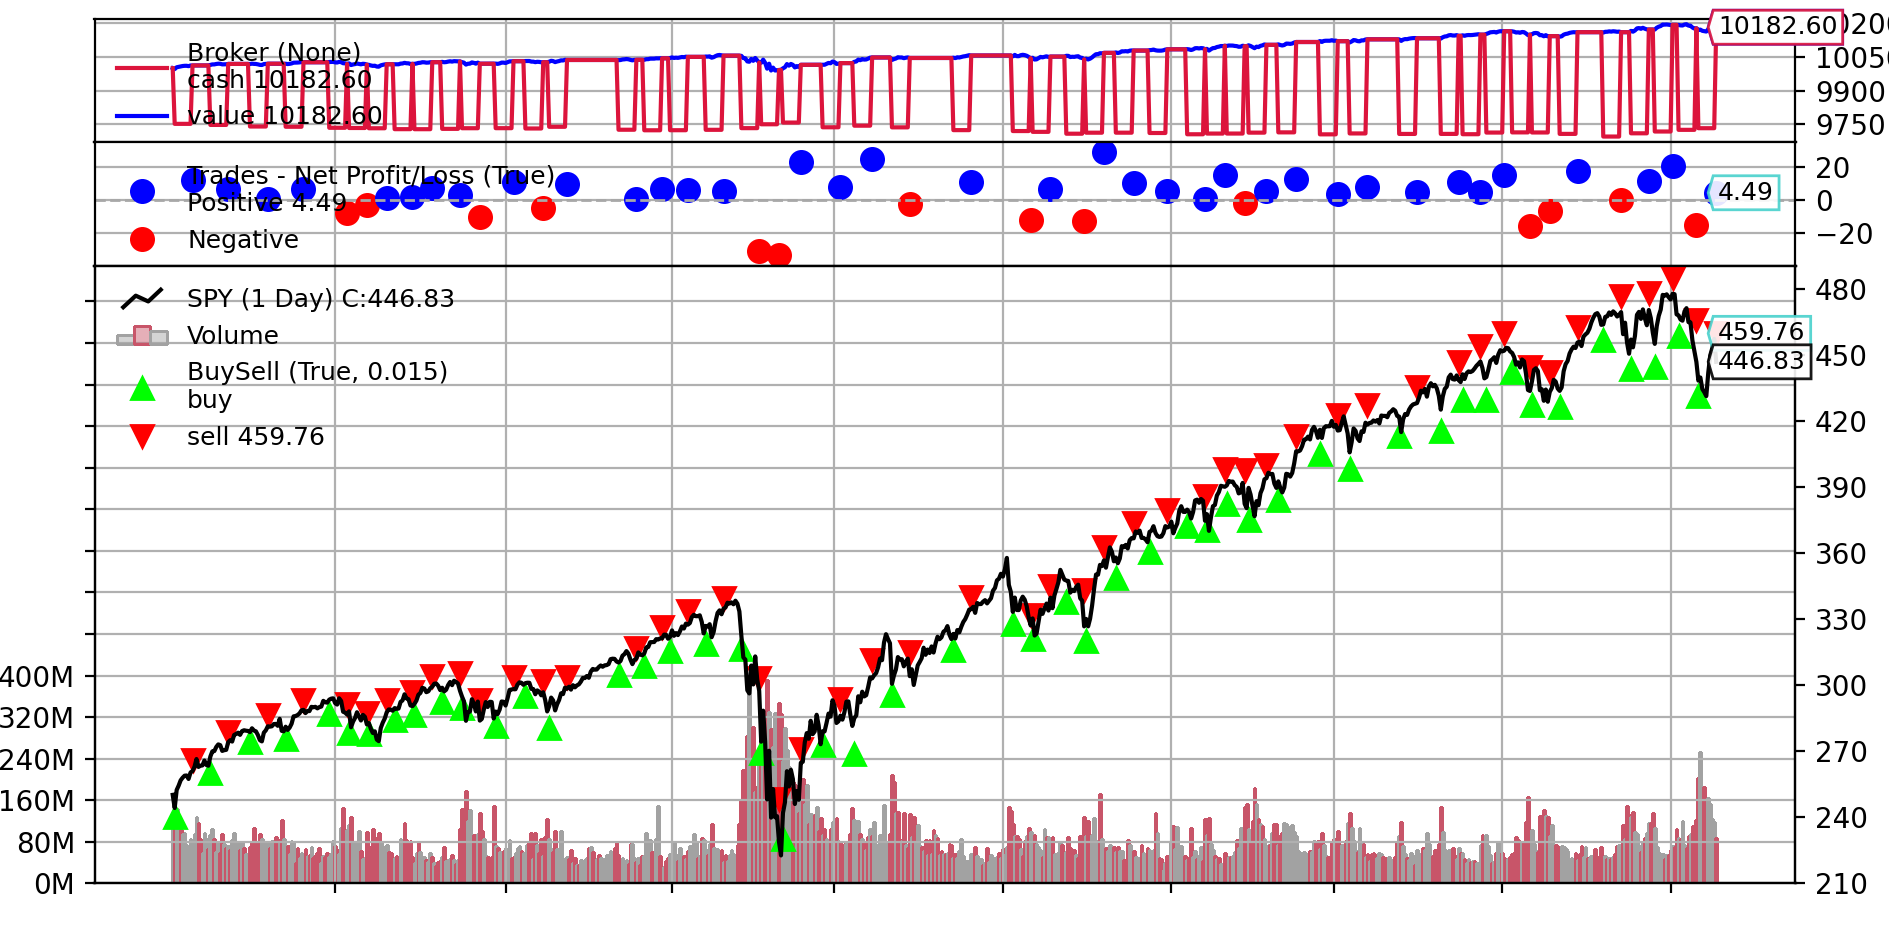

[[<Figure size 640x480 with 4 Axes>]]

In [104]:
cerebro.plot()

In [78]:
10181.948563700002-10000

181.9485637000016

In [79]:
173.81782370000005

173.81782370000005

In [80]:
181.9485637000016-173.81782370000005 # Tied in to the position

8.130740000001566

<IPython.core.display.Javascript object>


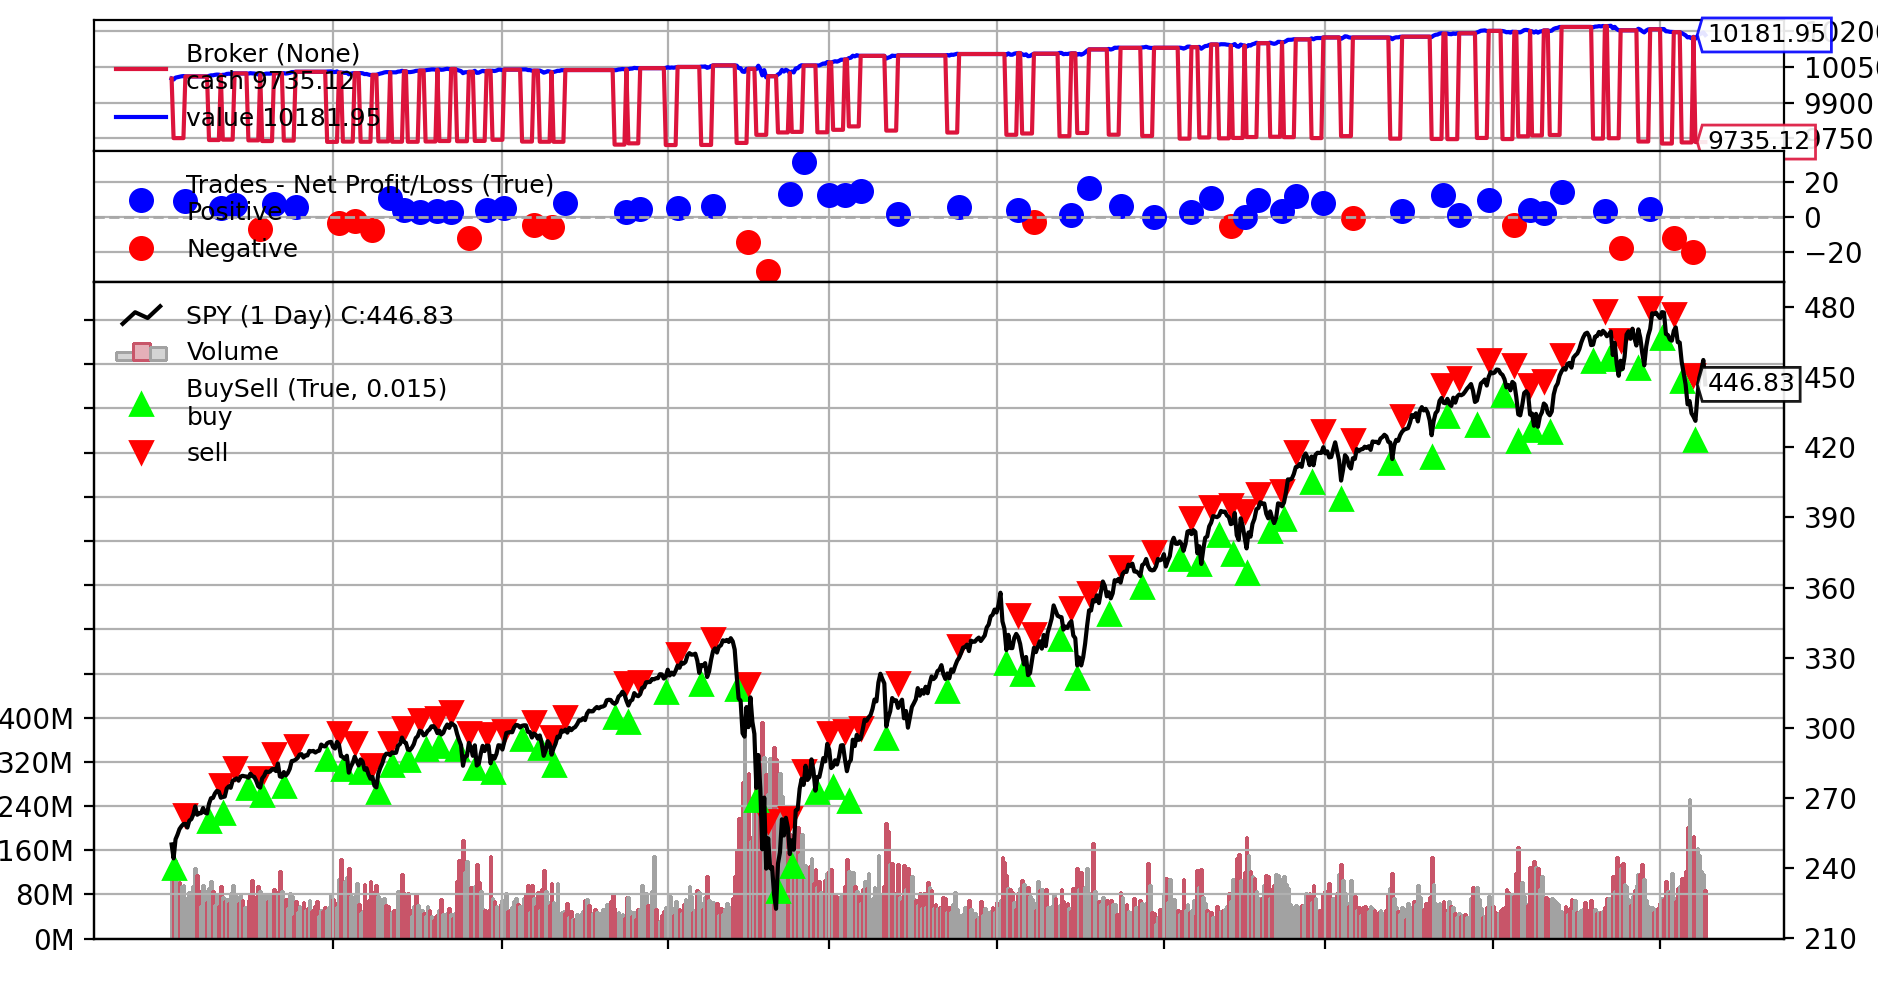

[[<Figure size 640x480 with 4 Axes>]]

In [89]:
cerebro.plot(width=20)